In [24]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel(r'Datasets\Signal investors list.xlsx')
df.head()
df.info()
# 1. Remove leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# 2. Standardize column names (replace spaces with underscores)
df.columns = (df.columns
              .str.replace(".", "")
              .str.replace(" ", "_")
              .str.lower()
              )

# 3. Remove duplicate rows
df = df.drop_duplicates()

# 4. Remove rows where ALL values are NaN
df = df.dropna(how='all')

# Remove rows where key columns are NaN (optional)
key_columns = ['f_name', 'l_name', 'fund']
df = df.dropna(subset=key_columns)

# 5. Standardize text columns (strip extra spaces)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

# 6. Convert date columns to datetime format (if not already)
date_columns = ['recent']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# 7. Handle missing values
# Fill numeric NaNs with 0
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(0)

# Fill non-numeric NaNs with 'Not Listed'
non_num_cols = df.select_dtypes(exclude='number').columns
df[non_num_cols] = df[non_num_cols].fillna('Not Listed')


# Save cleaned dataset
df.to_excel("Cleaned_Datasets/cleaned_signal_investors.xlsx", index=False)
missing_summary = df.isna().sum().sort_values(ascending=False)
missing_summary = missing_summary[missing_summary > 0]
print(missing_summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Pre-Seed      999 non-null    object        
 1   Seed          999 non-null    object        
 2   Emailed       0 non-null      float64       
 3   Unnamed: 3    1 non-null      object        
 4   F. Name       715 non-null    object        
 5   L. Name       715 non-null    object        
 6   Affiliation   579 non-null    object        
 7   Position      704 non-null    object        
 8   Email         2 non-null      object        
 9   Signal        714 non-null    object        
 10  Twitter       288 non-null    object        
 11  AngelList     213 non-null    object        
 12  LinkedIn      437 non-null    object        
 13  LI            77 non-null     float64       
 14  City          323 non-null    object        
 15  State/Region  240 non-null    object    

- EDA

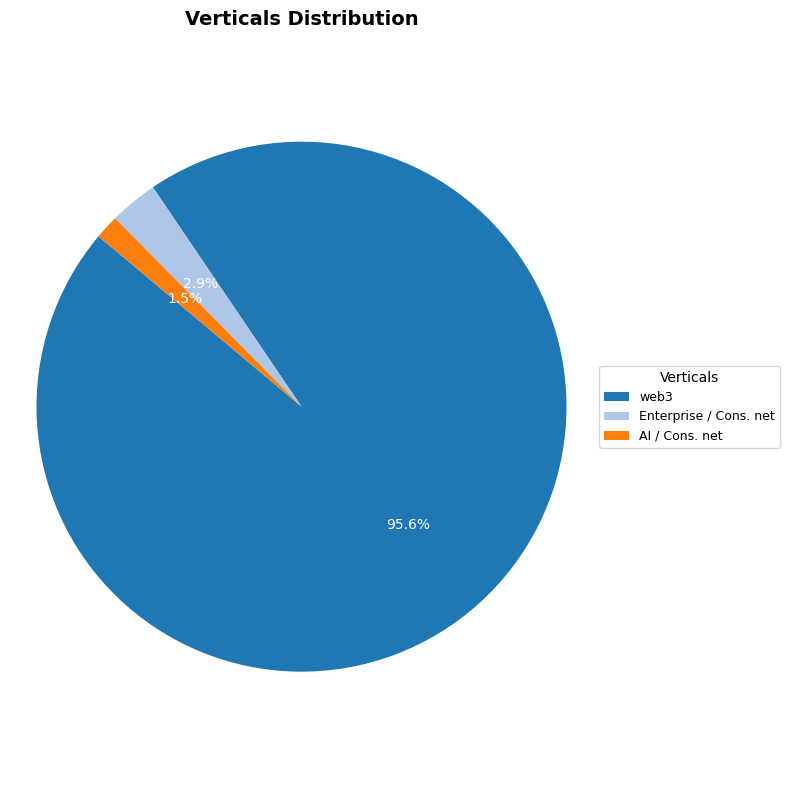

In [25]:
# Filter out 'Not Listed'
verticals_filtered = df[df['verticals'] != 'Not Listed']

# Get counts (you can also limit to top N if desired)
vertical_counts = verticals_filtered['verticals'].value_counts()

# Define a readable color palette (you can change 'tab20' to any Matplotlib colormap or seaborn palette)
colors = plt.cm.tab20.colors  # e.g., plt.cm.Set3.colors, sns.color_palette("pastel"), etc.

# Plot as pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    vertical_counts,
    labels=None,  # Keep labels out of pie for cleaner look
    colors=colors[:len(vertical_counts)],
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10, 'color': 'white'}  # Improve percentage readability
)

# Add legend instead of inline labels
ax.legend(
    wedges,
    vertical_counts.index,
    title="Verticals",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=9,
    title_fontsize=10
)

# Title
plt.title("Verticals Distribution", fontsize=14, weight='bold')

# Make chart circular & avoid cutoff in exports
plt.axis('equal')  
plt.tight_layout()

# Save as high-res PNG to avoid cutoff in README/PDF
plt.savefig('Images/Verticals_Distribution.png', dpi=300, bbox_inches='tight')

plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_2096\531746560.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


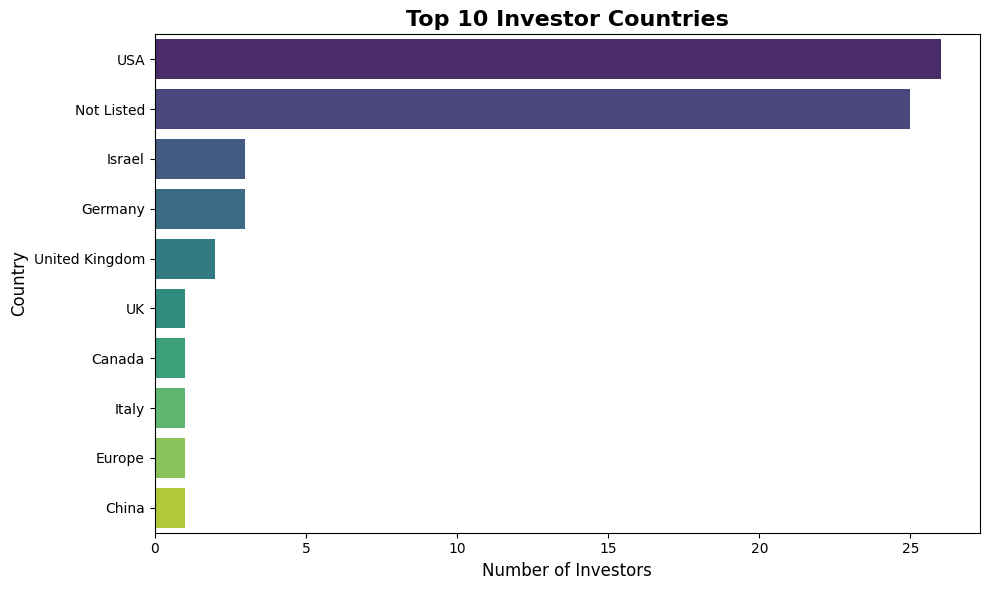

In [26]:
# Drop 'Notlisted'
df_filtered = df[df['country'] != 'Notlisted'].copy()

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(
    y='country', 
    data=df_filtered, 
    order=df_filtered['country'].value_counts().nlargest(10).index,
    palette='viridis'
)
plt.title("Top 10 Investor Countries", fontsize=16, weight='bold')
plt.xlabel("Number of Investors", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save with tight layout so nothing gets cut
plt.tight_layout()
plt.savefig('Images/Investors_by_Country.png', dpi=300, bbox_inches='tight')
plt.show()


- Who do we have?

C:\Users\user\AppData\Local\Temp\ipykernel_2096\2365680168.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


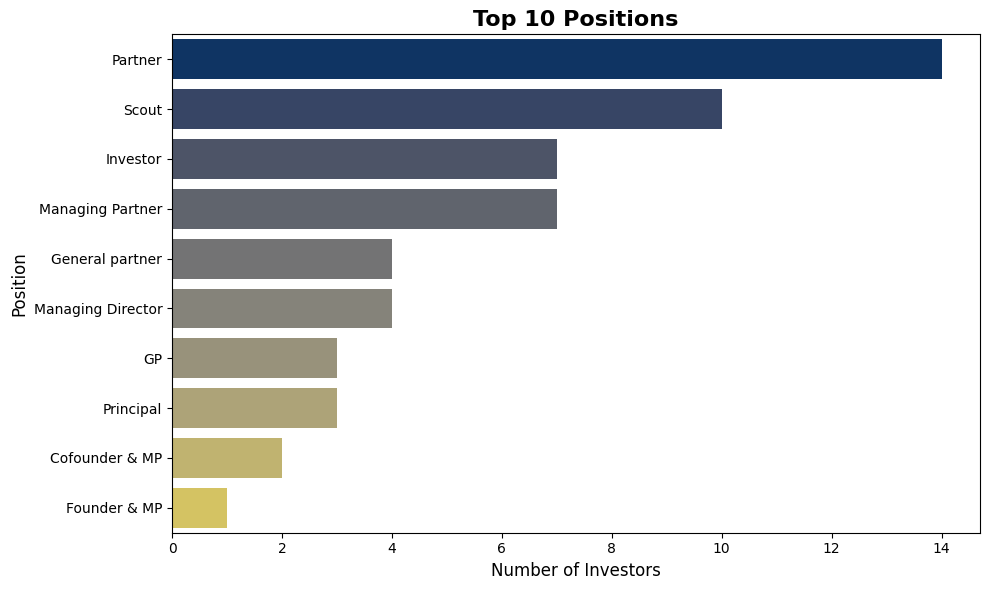

In [27]:
# Drop 'Not Listed'
df_positions = df[df['position'] != "Not Listed"].copy()

# Get top 10 positions
top10_positions = df_positions['position'].value_counts().nlargest(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top10_positions.values,
    y=top10_positions.index,
    palette='cividis'  # Professional alternative to 'viridis'
)

# Title & labels
plt.title("Top 10 Positions", fontsize=16, weight='bold')
plt.xlabel("Number of Investors", fontsize=12)
plt.ylabel("Position", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save cleanly
plt.tight_layout()
plt.savefig('Images/Top10_positions.png', dpi=300, bbox_inches='tight')
plt.show()


- What do they want?

In [28]:
# Fill missing values to avoid errors
df[['verticals', 'range', 'avg_check', 'affiliation']] = (
    df[['verticals', 'range', 'avg_check', 'affiliation']].fillna('Unknown')
)

# Group by position and summarize
top_positions_needs = (
    df.groupby('position')
    .agg({
        'verticals': lambda x: x.value_counts().index[0],   # Most common vertical
        'range': lambda x: x.value_counts().index[0],        # Most common investment range
        'avg_check': 'mean',                                 # Average check size
        'affiliation': lambda x: x.value_counts().index[0]   # Most common affiliation
    })
    .reset_index()  # <-- Keep position as a column
)

# Rename columns (keep 'position' intact)
top_positions_needs.columns = [
    'position', 'most_common_verticals', 'most_common_range',
    'avg_check_size', 'most_common_affiliation'
]

# Ensure avg_check_size is numeric before formatting
top_positions_needs['avg_check_size'] = (
    pd.to_numeric(top_positions_needs['avg_check_size'], errors='coerce')
)

# Sort by largest average check size and keep top 10
top_positions_needs = top_positions_needs.nlargest(10, 'avg_check_size')

# Format avg_check_size as currency
top_positions_needs['avg_check_size'] = top_positions_needs['avg_check_size'].apply(lambda x: f"${x:,.0f}")

# Fill missing most_common_range
top_positions_needs['most_common_range'] = top_positions_needs['most_common_range'].fillna("Not Specified")

# Clean text formatting
top_positions_needs['most_common_verticals'] = top_positions_needs['most_common_verticals'].astype(str).str.title()
top_positions_needs['most_common_affiliation'] = top_positions_needs['most_common_affiliation'].astype(str).str.title()

# Reset index for a clean presentation table
top_positions_needs = top_positions_needs.reset_index(drop=True)

# Final presentation-ready table
top_positions_needs


,position,most_common_verticals,most_common_range,avg_check_size,most_common_affiliation
0,Co-Founder,Web3,$500k-$5M,"$1,000,000",Initialized / 776
1,Gp,Web3,$500k-$5M,"$1,000,000",Nfx
2,Pres. & COO,Web3,$100k-$1M,"$1,000,000",Coinbase Ventures
3,VP Biz Dev & Cofounder,Web3,$500k-$5M,"$1,000,000",Convex Labs
4,Managing Director,Web3,$50k-$1M,"$618,750",Slow Ventures
5,Principal,Web3,$500k-$2M,"$600,000",Slow Ventures
6,General partner,Web3,$50k-$2M,"$587,500",Primomiglio Sgr
7,Managing Partner,Web3,$750k-$5M,"$521,429",Upfront Ventures
8,Analyst,Web3,$500K - $5.0M,"$500,000",Hartmann Capital
9,Cofounder & GP,Not Listed,$100k-$1M,"$500,000",Firstminute Capital
